In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from tqdm import tqdm


PARQUET_PATH = "df_60s.parquet"
WINDOW       = 30
EPOCHS       = 12
BATCH_SIZE   = 128
SCALE_FACTOR = 1_000.0
feature_cols = [
    "log_ret_mean", "log_ret_std", "log_ret_sum",
    "abs_volatility", "spread", "imbalance",
    "depth_ratio", "rv_rolling", "mom_rolling"
]
target_col = "realized_volatility"
tf.random.set_seed(42)


df = pd.read_parquet(PARQUET_PATH)
df["date"] = pd.to_datetime(df["date"])
df["day_of_week"] = df["date"].dt.dayofweek + 1  


cluster 0

C0‑predict: 100%|██████████| 558/558 [05:42<00:00,  1.63it/s]


C0 R² = 0.7461183823709919


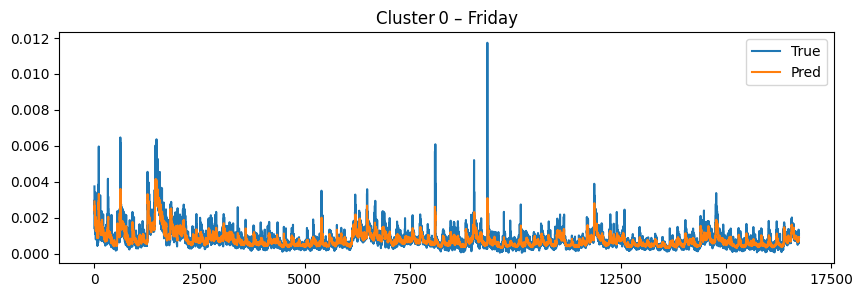

In [2]:
cl_id = 0                     
sub_c0 = df[df["cluster"] == cl_id].copy()


c0_X_tr, c0_y_tr = [], []
for _, g in tqdm(sub_c0[sub_c0.day_of_week <= 4].groupby(["stock_id","time_id"]),
                 desc="C0‑train"):
    g = g.sort_values("bucket_start")
    for i in range(WINDOW, len(g)):
        c0_X_tr.append(g.iloc[i-WINDOW:i][feature_cols].values)
        c0_y_tr.append(g.iloc[i][target_col])

c0_X_tr = np.array(c0_X_tr)
c0_y_tr = np.array(c0_y_tr)
n_feat  = c0_X_tr.shape[2]

c0_scaler = StandardScaler()
c0_X_tr_s = c0_scaler.fit_transform(c0_X_tr.reshape(-1, n_feat)).reshape(c0_X_tr.shape)
c0_y_tr_t = np.log1p(c0_y_tr) * SCALE_FACTOR

c0_model = Sequential([
    LSTM(64, input_shape=(WINDOW, n_feat)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1)
])
c0_model.compile(optimizer="adam", loss="mse")
c0_model.fit(c0_X_tr_s, c0_y_tr_t, epochs=EPOCHS,
             batch_size=BATCH_SIZE, validation_split=0.1, verbose=0)


c0_pred, c0_true = [], []
for _, g in tqdm(sub_c0[sub_c0.day_of_week == 5].groupby(["stock_id","time_id"]),
                 desc="C0‑predict"):
    g     = g.sort_values("bucket_start")
    feats = c0_scaler.transform(g[feature_cols].values)
    for i in range(WINDOW, len(g)):
        c0_true.append(g.iloc[i][target_col])
        y_hat = c0_model.predict(feats[i-WINDOW:i]
                                 .reshape(1, WINDOW, n_feat), verbose=0)[0,0]
        c0_pred.append(np.expm1(y_hat / SCALE_FACTOR))

c0_true = np.array(c0_true)
c0_pred = np.array(c0_pred)


c0_mae  = np.abs(c0_true - c0_pred)
c0_mse  = (c0_true - c0_pred)**2
c0_rmse = np.sqrt(c0_mse)
print("C0 R² =", r2_score(c0_true, c0_pred))


plt.figure(figsize=(10,3))
plt.plot(c0_true, label="True")
plt.plot(c0_pred, label="Pred")
plt.title("Cluster 0 – Friday")
plt.legend(); plt.show()


cluster 1

C1‑predict: 100%|██████████| 786/786 [08:16<00:00,  1.58it/s]

C1 R² = 0.7373946498078702


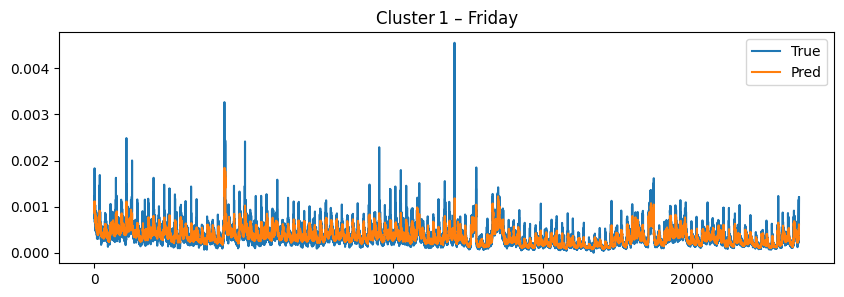

In [3]:
cl_id = 1                   
sub_c1 = df[df["cluster"] == cl_id].copy()

c1_X_tr, c1_y_tr = [], []
for _, g in tqdm(sub_c1[sub_c1.day_of_week <= 4].groupby(["stock_id","time_id"]),
                 desc="C1‑train"):
    g = g.sort_values("bucket_start")
    for i in range(WINDOW, len(g)):
        c1_X_tr.append(g.iloc[i-WINDOW:i][feature_cols].values)
        c1_y_tr.append(g.iloc[i][target_col])

c1_X_tr = np.array(c1_X_tr)
c1_y_tr = np.array(c1_y_tr)
n_feat  = c1_X_tr.shape[2]

c1_scaler = StandardScaler()
c1_X_tr_s = c1_scaler.fit_transform(c1_X_tr.reshape(-1, n_feat)).reshape(c1_X_tr.shape)
c1_y_tr_t = np.log1p(c1_y_tr) * SCALE_FACTOR

c1_model = Sequential([
    LSTM(64, input_shape=(WINDOW, n_feat)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1)
])
c1_model.compile(optimizer="adam", loss="mse")
c1_model.fit(c1_X_tr_s, c1_y_tr_t, epochs=EPOCHS,
             batch_size=BATCH_SIZE, validation_split=0.1, verbose=0)

c1_pred, c1_true = [], []
for _, g in tqdm(sub_c1[sub_c1.day_of_week == 5].groupby(["stock_id","time_id"]),
                 desc="C1‑predict"):
    g     = g.sort_values("bucket_start")
    feats = c1_scaler.transform(g[feature_cols].values)
    for i in range(WINDOW, len(g)):
        c1_true.append(g.iloc[i][target_col])
        y_hat = c1_model.predict(feats[i-WINDOW:i]
                                 .reshape(1, WINDOW, n_feat), verbose=0)[0,0]
        c1_pred.append(np.expm1(y_hat / SCALE_FACTOR))

c1_true = np.array(c1_true)
c1_pred = np.array(c1_pred)

c1_mae  = np.abs(c1_true - c1_pred)
c1_mse  = (c1_true - c1_pred)**2
c1_rmse = np.sqrt(c1_mse)
print("C1 R² =", r2_score(c1_true, c1_pred))

plt.figure(figsize=(10,3))
plt.plot(c1_true, label="True")
plt.plot(c1_pred, label="Pred")
plt.title("Cluster 1 – Friday")
plt.legend(); plt.show()


cluster 2

C2‑predict: 100%|██████████| 636/636 [07:35<00:00,  1.40it/s]


C2 R² = 0.5246652814117511


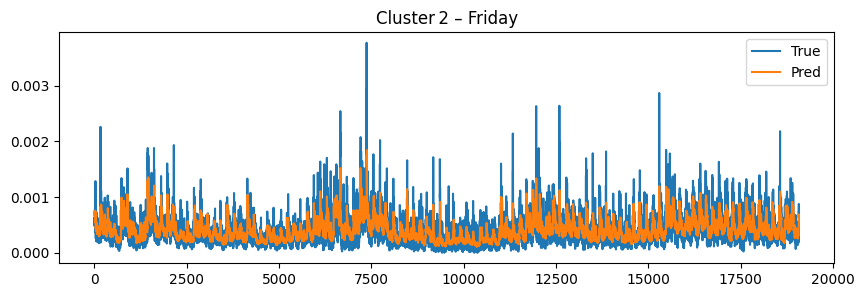

In [4]:
cl_id = 2                     
sub_c2 = df[df["cluster"] == cl_id].copy()

c2_X_tr, c2_y_tr = [], []
for _, g in tqdm(sub_c2[sub_c2.day_of_week <= 4].groupby(["stock_id","time_id"]),
                 desc="C2‑train"):
    g = g.sort_values("bucket_start")
    for i in range(WINDOW, len(g)):
        c2_X_tr.append(g.iloc[i-WINDOW:i][feature_cols].values)
        c2_y_tr.append(g.iloc[i][target_col])

c2_X_tr = np.array(c2_X_tr)
c2_y_tr = np.array(c2_y_tr)
n_feat  = c2_X_tr.shape[2]

c2_scaler = StandardScaler()
c2_X_tr_s = c2_scaler.fit_transform(c2_X_tr.reshape(-1, n_feat)).reshape(c2_X_tr.shape)
c2_y_tr_t = np.log1p(c2_y_tr) * SCALE_FACTOR

c2_model = Sequential([
    LSTM(64, input_shape=(WINDOW, n_feat)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1)
])
c2_model.compile(optimizer="adam", loss="mse")
c2_model.fit(c2_X_tr_s, c2_y_tr_t, epochs=EPOCHS,
             batch_size=BATCH_SIZE, validation_split=0.1, verbose=0)

c2_pred, c2_true = [], []
for _, g in tqdm(sub_c2[sub_c2.day_of_week == 5].groupby(["stock_id","time_id"]),
                 desc="C2‑predict"):
    g     = g.sort_values("bucket_start")
    feats = c2_scaler.transform(g[feature_cols].values)
    for i in range(WINDOW, len(g)):
        c2_true.append(g.iloc[i][target_col])
        y_hat = c2_model.predict(feats[i-WINDOW:i]
                                 .reshape(1, WINDOW, n_feat), verbose=0)[0,0]
        c2_pred.append(np.expm1(y_hat / SCALE_FACTOR))

c2_true = np.array(c2_true)
c2_pred = np.array(c2_pred)

c2_mae  = np.abs(c2_true - c2_pred)
c2_mse  = (c2_true - c2_pred)**2
c2_rmse = np.sqrt(c2_mse)
print("C2 R² =", r2_score(c2_true, c2_pred))

plt.figure(figsize=(10,3))
plt.plot(c2_true, label="True")
plt.plot(c2_pred, label="Pred")
plt.title("Cluster 2 – Friday")
plt.legend(); plt.show()


Result Visualisation

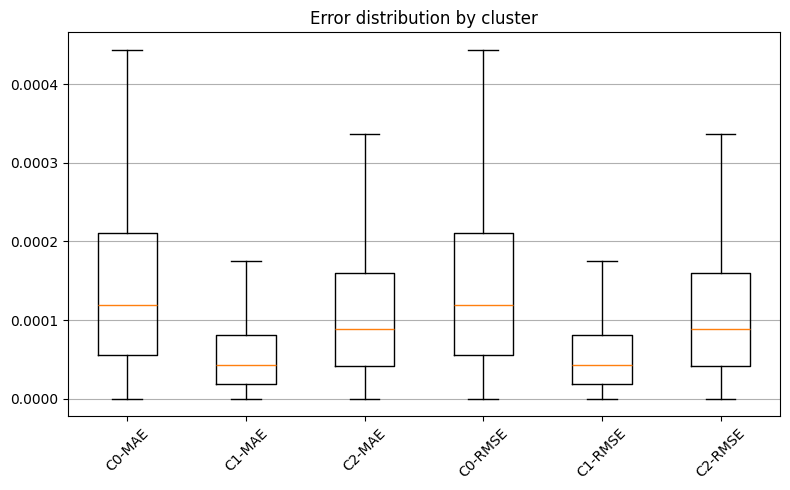

In [7]:
plt.figure(figsize=(8,5))
plt.boxplot(
    [c0_mae, c1_mae, c2_mae,
     c0_rmse,c1_rmse,c2_rmse],
    labels=["C0-MAE","C1-MAE","C2-MAE",
            "C0-RMSE","C1-RMSE","C2-RMSE"],
    showfliers=False
)
plt.xticks(rotation=45)
plt.title("Error distribution by cluster")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


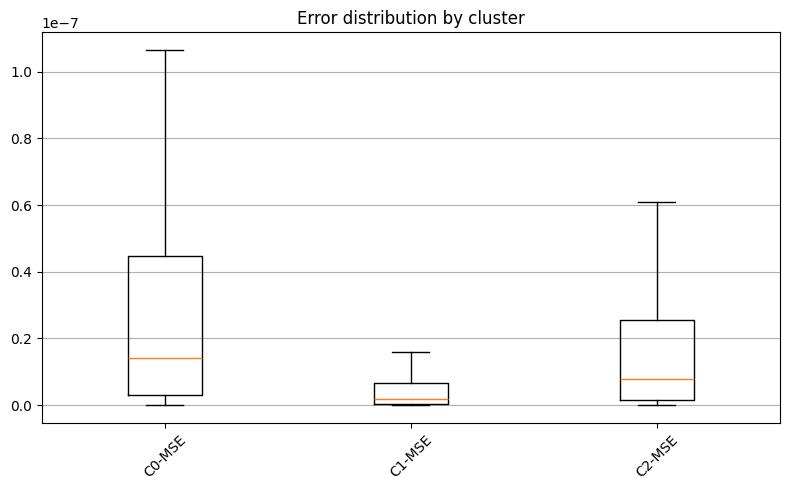

In [6]:
plt.figure(figsize=(8,5))
plt.boxplot(
    [c0_mse, c1_mse, c2_mse],
    labels=["C0-MSE","C1-MSE","C2-MSE"],
    showfliers=False
)
plt.xticks(rotation=45)
plt.title("Error distribution by cluster")
plt.grid(axis="y")
plt.tight_layout()
plt.show()